In [25]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import eli5



pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


# Funciones Generales

In [26]:
NOTICIEROS = ['cnn', 'bbc', 'reuters', 'blomberg', 'herald', 'today', 'herald', 'abc', 'fox', 'cbs', \
            'yorker', 'daily', 'financial', 'guardian', 'sun', 'observer', 'five', 'jazeera', 'news', 'live']

PAIS_DESASTRES = ['usa', 'united states', 'canada', 'island', 'japan', 'nigeria', 'turkey', 'saudi', \
                  'malaysia']

CIUDAD_DESASTRES = ['california', 'new york', 'nyc', 'hawaii', 'hiroshima', 'fukushima', 'calgary']
 
DESASTRES_CONOCIDOS = ['mh370', 'air', 'huracan', 'fire', 'water', 'kill', 'disaster', 'suicide', 'police', 'people', \
                      'flood', 'police', 'home', 'family', 'train', 'storm', 'building', 'crash', 'hiroshima', \
                      'bomb', 'isis', 'bombing', 'wreckage', 'earthquake', 'wild', 'wildfire', 'weather', \
                      'violent', 'attack', 'tornado', 'traffic', 'thunder', 'terror', 'suspect', 'swallow',\
                      'sin', 'severe', 'security', 'refugee', 'refugio', 'release', 'report', 'rescue', 'plane',\
                      'passenger', 'offic', 'nuclear', 'north', 'natural', 'national', 'murder', 'migrant', \
                      'mass', 'land', 'issue', 'hurricane', 'injured', 'hostage', 'flood', 'evacua']
ZONAS_CONFLICTO = ['israel', 'iran', 'turkey']




CORTE_LENGHT_TEXT = 100

#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix (y_test, y_pred))

    # Obtener y reformar la matriz de datos de 
    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)

    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()
    
def grafico_distr(df, columna, titulo, xtitulo, ytitulo):
    x1 = df.loc[df['target'] == 1][columna]
    x2 = df.loc[df['target'] == 0][columna]
    group_labels = ['Verdadero', 'Falso']
    colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
    fig = ff.create_distplot([x1, x2], group_labels,colors=colors)
    fig.update_layout(title_text=titulo,
                      xaxis_title=xtitulo,
                      yaxis_title=ytitulo,
                      template="plotly_white")
    fig.show()

# Referencia a un diario o noticiero
def news_ref(text):
    for word in NOTICIEROS:
        if word in text:
            return True
    return False

#Categoría ancho mensajes
def text_lenght_category(text):
    if len(text) > CORTE_LENGHT_TEXT:
        return True
    else:
        return False
def desastre_conocido(text):
    for dis in DESASTRES_CONOCIDOS:
        if dis in text:
            return True
    return False

#Pais de desastre
def es_pais_de_desastres(text):
    for word in text.split():
        if word in PAIS_DESASTRES:
            return True
    return False

#Ciudad de desastre
def es_ciudad_de_desastres(text):
    for word in text.split():
        if word in CIUDAD_DESASTRES:
            return True
    return False

def resultados(pred, test_df):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)
    
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.tag import pos_tag
from textblob import TextBlob

import re, string
from string import punctuation


stops = set(stopwords.words('english'))
punctuation = list(string.punctuation)
#punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]“”^_`{|}~’'


word_list = brown.words()
word_set = set(word_list)

def eliminar_char_espec(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text
def idioma(text):
    tb = TextBlob(text)
    return tb.detect_language()

def sentimiento(text):
    tb = TextBlob(text)
    return tb.sentiment[0]

def unir_texto(text):
    return ( ' '.join(text))

def eliminar_palabras_con(text, con):
    palabras = []
    for word in text.split():
        if con not in word:
            palabras.append(word)
    return unir_texto(palabras)


# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Elimino stops words 
def eliminar_sw(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stops: 
            pos = pos_tag([i.strip()])
            #word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(i.strip())
    return unir_texto(final_text)
def cant_stopwords(text):
    cant = 0
    for i in text.split():
        if i.strip() in stops: 
            cant = cant + 1
    return cant
def minusculas(text):
    return text.lower()

def eliminar_nums(text):
    cadena = []
    for x in text:
         if x not in string.digits:
                cadena.append(x)
    return  ''.join(cadena)

def eliminar_punct(text):
    cadena = []
    for x in text:
         if x not in string.punctuation:
                cadena.append(x)
    return  ''.join(cadena)
        
#Generar CSV para el envio
def formatear_texto(text):
    text = minusculas(text)
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    #text = eliminar_palabras_con(text, '#')
    #text = eliminar_sw(text)
    text = eliminar_punct(text)
    text = eliminar_nums(text)
    text = eliminar_char_espec(text)
    return text.strip()
def eliminar_palabras_especiales(text):
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    #text = eliminar_palabras_con(text, '#')
    return text

def cant_err_ortograficos(text):
    cant = 0
    for w in text.split():
        if w not in word_set:
            cant = cant + 1
    return cant
def eliminar_cortas(text):
    cadena = []
    for word in text.split():
        if len(word) > 1:
            cadena.append(word)
    return  ' '.join(cadena)

def convertir_relevantes(text):
    #text = text.replace('\'','')
    text = text.replace('&amp', 'and')
    text = text.replace('?',' ')
    text = text.replace('-',' ')
    text = text.replace('iam','i am')
    text = text.replace('i\'m','i am')
    text = text.replace(' im ','i am')
    text = text.replace('cant','can not')
    text = text.replace(' u ',' you ')
    text = text.replace(' youre ',' you are ')
    text = text.replace(' lol ','')
    text = text.replace('rt ','')
    text = text.replace(' ive ',' i have ')
    text = text.replace(' hes ',' hi is ')
    text = text.replace(' thats ',' that is ')
    text = text.replace(' ill ',' i will ')
    text = text.replace(' yd ',' years ')
    text = text.replace('it s','its')
    text = text.replace('fvck','fuck')
    text = text.replace('pm','')
    text = text.replace(' rn ',' right now ')
    text = text.replace(' 3p ',' ')
    text = text.replace(' n ',' ')
    text = text.replace(' da ',' the ')
    text = text.replace('i ve','i have')
    return text

def formato_inicial(df):
    df['location'].fillna(value='sin location', inplace=True)
    df['keyword'].fillna(value='sin keyword', inplace=True)
    
    #Minúsculas
    df['keyword'] = df.keyword.str.lower()
    df['location'] = df.keyword.str.lower()
    df['keyword'] = df.keyword.str.replace('%20', ' ')
    df['location'] = df.location.str.replace('%20', ' ')
    
    #Sobre text_clean
    df['text_clean'] = df.text.str.replace('%20', ' ')
    df['text_clean'] = df.text_clean.apply(eliminar_palabras_especiales)


    
def nuevas_columnas(df):
    #Sobre el texto original
    df['cant_caracteres'] = df.text.str.len()
    
    #Sobre el texto formateado
    df['cant_stopwords'] = df.text_clean.apply(cant_stopwords)
    df['cant_palabras'] = df.text_clean.str.split().str.len()
    df['cant_mayus'] = df.text_clean.str.count(r'[A-Z]')
    df['text_clean'] = df.text_clean.str.lower()

    
    #Sobre lo calculado
    df['cant_stopwords_pct'] = df.cant_stopwords/df.cant_palabras
    df['cant_mayus_pct'] = df.cant_mayus/df.cant_caracteres

    
    #Sobre el léxico
    train_df['sentimiento'] = train_df.text_clean.apply(sentimiento)


# Carga de datos

In [27]:

'''
train_df['text_sin_sw'] = train_df.text.apply(convertir_relevantes)
train_df['text_sin_sw'] = train_df.text_sin_sw.apply(formatear_texto)
train_df['text_sin_sw'] = train_df.text_sin_sw.apply(eliminar_cortas)


train_df['keyword'] = train_df.keyword.str.lower()
train_df['keyword'] = train_df.keyword.str.replace('%20', ' ')


train_df['location'] = train_df.location.str.lower()
train_df['location'] = train_df.location.str.replace('%20', ' ')


train_df['word_count'] = train_df.text_sin_sw.str.split().str.len()
train_df['word_lenght'] = train_df.text.apply(len)

train_df['cant_stop_words'] = train_df.text_sin_sw.apply(cant_stopwords)
#train_df['cant_err_orto'] =train_df.text_sin_sw.apply(cant_err_ortograficos)

train_df['http'] = train_df.text.str.contains('http')
train_df['ref_noticias'] = train_df.text.apply(news_ref)



#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)
'''

train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')
formato_inicial(train_df)
nuevas_columnas(train_df)
train_df

,id,keyword,location,text,target,text_clean,cant_caracteres,cant_stopwords,cant_palabras,cant_mayus,cant_stopwords_pct,cant_mayus_pct,sentimiento
0,1,sin keyword,sin keyword,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this #earthquake may allah forgive us all,69,5,13,10,0.3846153846,0.1449275362,0.0000000000
1,4,sin keyword,sin keyword,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,38,0,7,5,0.0000000000,0.1315789474,0.1000000000
2,5,sin keyword,sin keyword,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected,133,9,22,2,0.4090909091,0.0150375940,-0.0187500000
3,6,sin keyword,sin keyword,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in california",65,1,8,1,0.1250000000,0.0153846154,0.0000000000
4,7,sin keyword,sin keyword,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school,88,6,16,3,0.3750000000,0.0340909091,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,sin keyword,sin keyword,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,two giant cranes holding a bridge collapse into nearby homes,83,2,10,1,0.2000000000,0.0120481928,0.0000000000
7609,10870,sin keyword,sin keyword,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,the out of control wild fires in california even in the northern part of the state. very troubling.,125,7,18,4,0.3888888889,0.0320000000,0.1500000000
7610,10871,sin keyword,sin keyword,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,m1.94 [01:04 utc]?5km s of volcano hawaii.,65,1,7,7,0.1428571429,0.1076923077,0.0000000000
7611,10872,sin keyword,sin keyword,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,police investigating after an e-bike collided with a car in little portugal. e-bike rider suffered serious non-life threatening injuries.,137,5,19,4,0.2631578947,0.0291970803,-0.2604166667


# Gráficos

In [28]:
grafico_distr(train_df, 'cant_palabras', 'Gráfico de distr. de cantidad de palabras en text',  'Cantidad', '')
grafico_distr(train_df, 'cant_caracteres','Gráfico de dist. de cantidad de caracteres en text', 'Cantidad', '')
grafico_distr(train_df, 'cant_stopwords_pct','Gráfico de distr. porcentual de stopwords en text', 'Porcentaje', '')
grafico_distr(train_df, 'cant_mayus_pct', 'Gráfico de distr. porcentual de mayúsculas en text','Porcentaje', '')



# A. Random Forest Classifier - Features

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1107
           1       0.59      0.57      0.58       797

    accuracy                           0.66      1904
   macro avg       0.65      0.64      0.64      1904
weighted avg       0.65      0.66      0.66      1904

[[797 310]
 [344 453]]


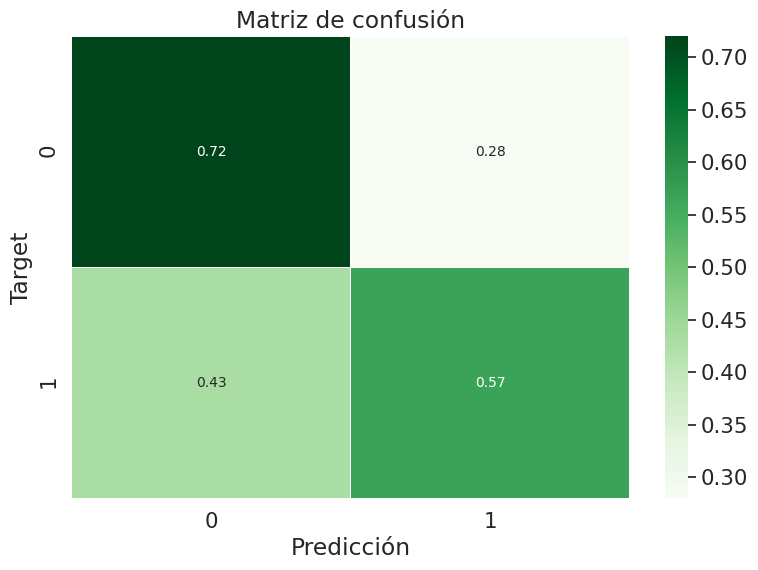

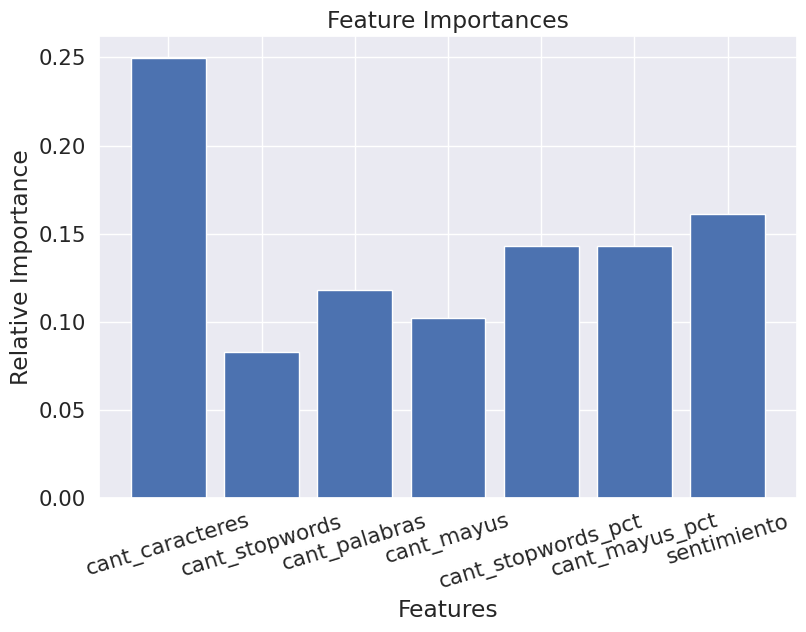

In [29]:
y = train_df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_clean']
X = train_df.drop(columnas, axis=1)



#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Train
RFC = RandomForestClassifier(n_estimators = 200,  max_depth=8, max_features='auto',
                             criterion='entropy', random_state = 0)

RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)


#Features
features = np.array(X.columns)
importances = RFC.feature_importances_

#Plot
plt.figure()
plt.bar(X_train.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.xticks(rotation=17)
plt.ylabel('Relative Importance')
plt.show()

'''

#Tree
tree0 = RFC.estimators_[0]
fig, axes = plt.subplots(nrows = 1, ncols = 1,  figsize=(9,6), dpi=200)
plot_tree(tree0, feature_names = X_train.columns, filled = True)
plt.show()


#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)


'''
print('')

# 1.  LSTM - TEXT

Found 15846 unique tokens.
Shape of data tensor: (7613, 30)
Shape of label tensor: (7613, 2)
(5709, 30) (5709, 2)
(1904, 30) (1904, 2)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
81/81 [==============================] - 7s 91ms/step - loss: 0.5914 - accuracy: 0.6736 - va

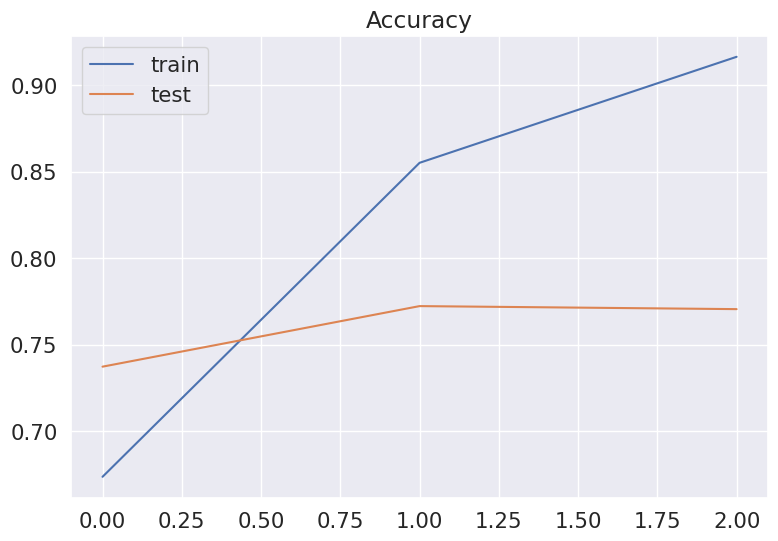

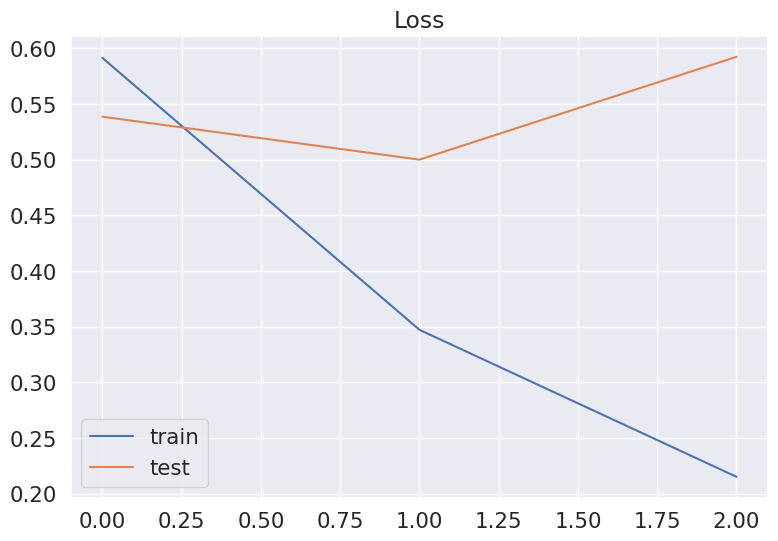

In [30]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

STOPWORDS = set(stopwords.words('english'))


# Cantidad de palabras a usar
MAX_NB_WORDS = 50000
# Número maximo de palabras en el campo text.
MAX_SEQUENCE_LENGTH = 30
# Fijo.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['text_clean'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(train_df['text_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(train_df['target']).values
print('Shape of label tensor:', Y.shape)



X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

#Graficos
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


# 2. XGBoost - TEXT

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1107
           1       0.77      0.64      0.70       797

    accuracy                           0.77      1904
   macro avg       0.77      0.75      0.75      1904
weighted avg       0.77      0.77      0.76      1904

[[951 156]
 [289 508]]


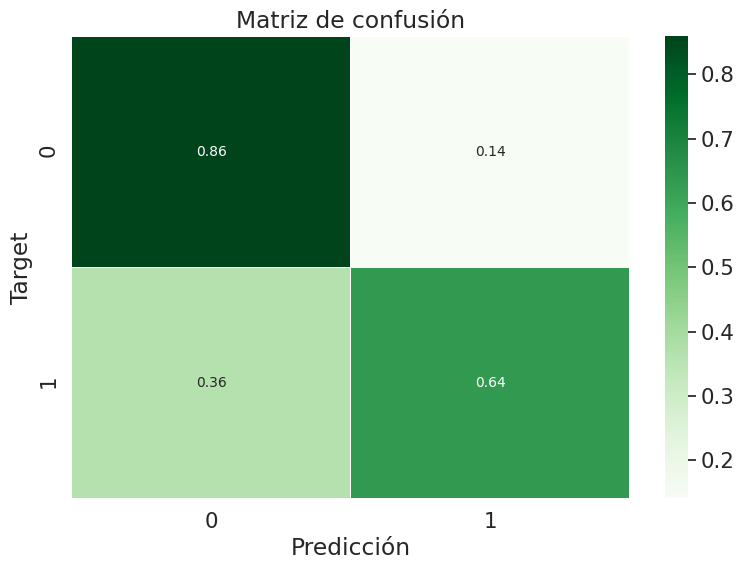

In [31]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento
alg = XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=17,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

alg.fit(X_train, y_train, eval_metric='auc')

#Predicciones
y_pred = alg.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

# 3.  Random Forest Classifier - TEXT

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      1107
           1       0.96      0.38      0.54       797

    accuracy                           0.73      1904
   macro avg       0.82      0.68      0.68      1904
weighted avg       0.80      0.73      0.70      1904

[[1093   14]
 [ 496  301]]


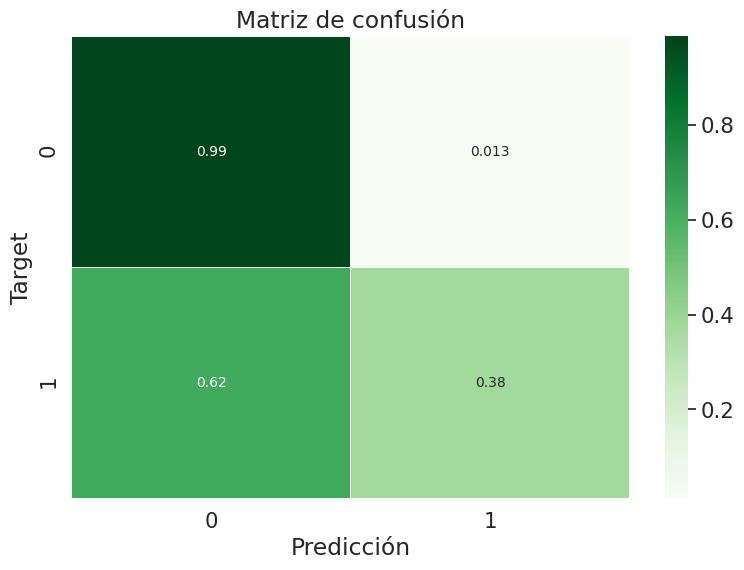

In [32]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
RFC = RandomForestClassifier(n_estimators = 500,  max_depth=25, max_features='auto',
                             criterion='entropy', n_jobs=-1)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

'''

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11, 13],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)
'''
print('')

# 4. Regresión Logística - TEXT

              precision    recall  f1-score   support

           0       0.78      0.92      0.85      1107
           1       0.85      0.64      0.73       797

    accuracy                           0.80      1904
   macro avg       0.82      0.78      0.79      1904
weighted avg       0.81      0.80      0.80      1904

[[1017   90]
 [ 283  514]]


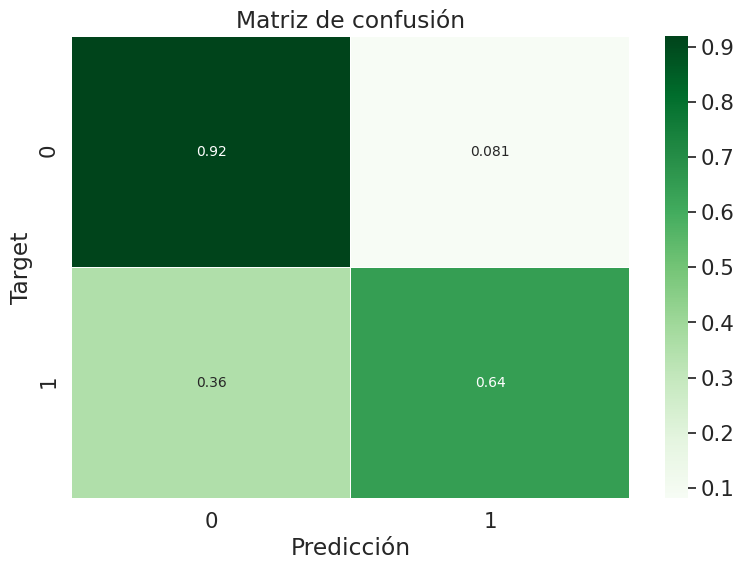

Weight?,Feature
+1.477,in
+1.010,california
+0.968,fires
+0.968,hiroshima
+0.805,of
+0.771,fire
+0.766,suicide
+0.713,after
+0.701,train
+0.682,killed


In [33]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento
LR = LogisticRegression(C=0.2, penalty= 'l2', multi_class='multinomial', n_jobs=4)
LR.fit(X_train, y_train)

#Métricas
y_pred = LR.predict(X_test)
mostrar_metricas(y_test, y_pred)

#Feature estimator
eli5.show_weights(estimator=LR,feature_names= list(count_vect.get_feature_names()),top=(20, 20))

# 5. KNN - TEXT

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1107
           1       0.85      0.62      0.72       797

    accuracy                           0.79      1904
   macro avg       0.81      0.77      0.78      1904
weighted avg       0.80      0.79      0.79      1904

[[1017   90]
 [ 303  494]]


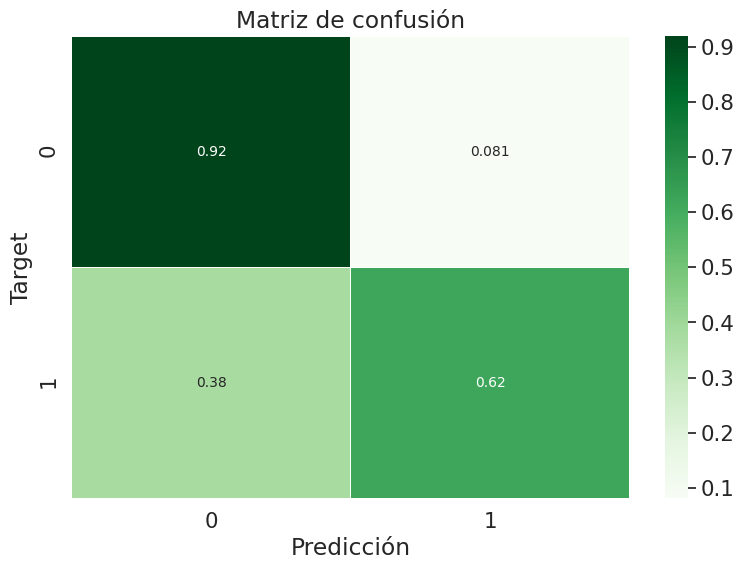

In [37]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 80, metric='minkowski')
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
mostrar_metricas(y_test, y_pred)

'''

#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k, metric='minkowski')
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()

'''
print('')

# 6. Multinomial NB - TEXT

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1107
           1       0.85      0.63      0.73       797

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.78      1904
weighted avg       0.81      0.80      0.79      1904

[[1017   90]
 [ 292  505]]


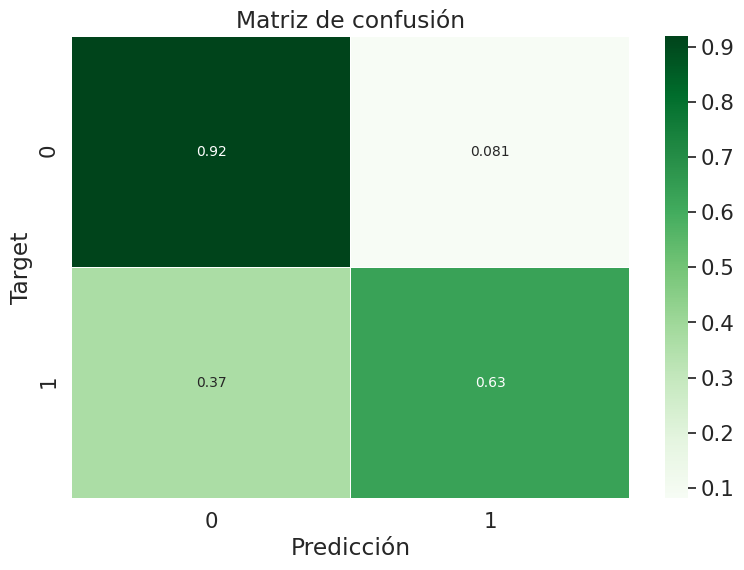

In [36]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred = MNB.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)